### В данном уроке мы выделим еще несколько потенциально важных фичей из изначального датасета и попробуем применить изученные методы отбора признаков к итоговому датасету.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd

processed_data = pd.read_csv('/content/drive/MyDrive/csv/processed_data-4.csv', index_col='id')

processed_data.head()

,vendor_id,passenger_count,store_and_fwd_flag,distance_km,log_trip_duration
id,,,,,
id2875421,1,930.399753,0,1.500479,6.122493
id2377394,0,930.399753,0,1.807119,6.498282
id3858529,1,930.399753,0,6.392080,7.661527
id3504673,1,930.399753,0,1.487155,6.063785
id2181028,1,930.399753,0,1.189925,6.077642


In [3]:
initial_data = pd.read_csv('/content/drive/MyDrive/csv/taxi_dataset.csv')

initial_data.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N


In [4]:
initial_data.shape[0] == processed_data.shape[0]

True

In [5]:
### Вернем в датасет колонку pickup_datetime

initial_data = initial_data.set_index('id')

processed_data = pd.merge(processed_data, initial_data['pickup_datetime'],
                          left_index=True, right_index=True)

In [6]:
processed_data.head()

,vendor_id,passenger_count,store_and_fwd_flag,distance_km,log_trip_duration,pickup_datetime
id,,,,,,
id2875421,1,930.399753,0,1.500479,6.122493,2016-03-14 17:24:55
id2377394,0,930.399753,0,1.807119,6.498282,2016-06-12 00:43:35
id3858529,1,930.399753,0,6.392080,7.661527,2016-01-19 11:35:24
id3504673,1,930.399753,0,1.487155,6.063785,2016-04-06 19:32:31
id2181028,1,930.399753,0,1.189925,6.077642,2016-03-26 13:30:55


Напомним, **pickup_datetime** - время начала поездки.

Кажется, что в зависимости от месяца/дня недели/времени суток движение на дорогах может отличаться. Как из-за погодных условий, так и из-за загруженности транспорта. Поэтому, есть подозрение, что будет полезно выделить ряд признаков из колонки **pickup_datetime**. Давайте исследуем зависимость нашей таргетной переменной от указанных факторов.

In [7]:
processed_data['pickup_datetime'] = pd.to_datetime(processed_data['pickup_datetime'])

processed_data['date'] = processed_data.pickup_datetime.dt.date
processed_data['day_of_week'] = processed_data.pickup_datetime.dt.dayofweek
processed_data['hour'] = processed_data.pickup_datetime.dt.hour
processed_data['month'] = processed_data.pickup_datetime.dt.month

In [8]:
processed_data.head()

,vendor_id,passenger_count,store_and_fwd_flag,distance_km,log_trip_duration,pickup_datetime,date,day_of_week,hour,month
id,,,,,,,,,,
id2875421,1,930.399753,0,1.500479,6.122493,2016-03-14 17:24:55,2016-03-14,0,17,3
id2377394,0,930.399753,0,1.807119,6.498282,2016-06-12 00:43:35,2016-06-12,6,0,6
id3858529,1,930.399753,0,6.392080,7.661527,2016-01-19 11:35:24,2016-01-19,1,11,1
id3504673,1,930.399753,0,1.487155,6.063785,2016-04-06 19:32:31,2016-04-06,2,19,4
id2181028,1,930.399753,0,1.189925,6.077642,2016-03-26 13:30:55,2016-03-26,5,13,3


In [9]:
mean_for_day = processed_data.groupby(["month","day_of_week"])["log_trip_duration"].mean()
s= []
for i in processed_data["month"].unique():
  sum = 0
  for j in processed_data["day_of_week"].unique():
    sum += mean_for_day[i,j]
  s.append(sum/7)

s

[6.4467694710347825,
 6.511301696663935,
 6.420208091416461,
 6.480458968347699,
 6.509189076158315,
 6.423008873560799]

Исследуем, когда и сколько поездок было совершено. 

Начнем с графиков, показывающих количество поездок в зависимости от времени суток/даты и т.д.

Так же полезно сразу показать и среднее значение таргетной переменной.

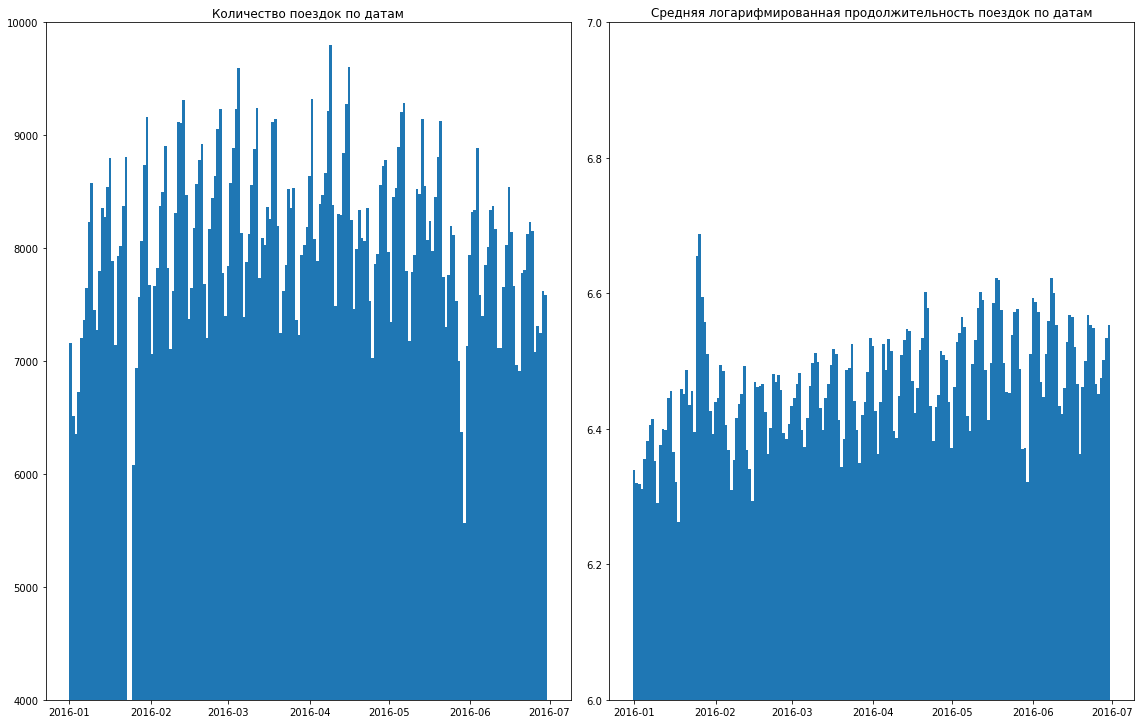

In [10]:
import matplotlib.pyplot as plt

fig = plt.figure()

fig.set_size_inches(16, 10)

ax_1 = fig.add_subplot(1, 2, 1)
plt.hist(processed_data['date'], bins=processed_data.date.unique().shape[0])
plt.ylim((4000, 10000))

ax_2 = fig.add_subplot(1, 2, 2)
plt.bar(sorted(list(processed_data['date'].unique())), 
        processed_data.groupby('date', as_index=False)['log_trip_duration'].mean()['log_trip_duration'],
        width=1)
plt.ylim((6, 7))

fig.tight_layout()

ax_1.set(title = 'Количество поездок по датам')
ax_2.set(title = 'Средняя логарифмированная продолжительность поездок по датам')

plt.show()

In [11]:
processed_data.groupby('date', as_index=False)['log_trip_duration'].count()['log_trip_duration'].sort_values()

22     1648
23     3383
150    5570
24     6084
2      6353
       ... 
43     9309
92     9325
64     9597
106    9602
99     9796
Name: log_trip_duration, Length: 182, dtype: int64

Кажется, что внутри недели есть некоторая зависимость таргета от дня недели. 

Такая же зависимость может оказаться и внутри дня (в завимости от часов).

Предлагаю исследовать эту зависимость подробнее.

Изобразите следующие графики зависимостей:

- Количество поездок/Средняя продолжительность поездки vs День недели
- Количество поездок/Средняя продолжительность поездки vs время суток
- Средняя продолжительность поездки vs время суток для каждого дня недели (например, нарисовав с разными цветами и, соответственно, легендами)
- Аналогичные графики, используя информацию о месяце, внутри которого была совершена поездка.
- Ящики с усами для различных: времени суток, дня недели, месяца

Используйте любые доступные инструменты pyplot!

Далее, на основе полученных результатов, мы будем принимать решение о создании новых признаков.

EDA можно использовать не только для того, чтобы понять, какие фичи можно убрать из датасета. Но и для выделения базовых признаков. Этим и займемся!

P.S. Сами графики мы проверять у Вас не будем. Зато для ответа на устные вопросы понадобятся, поэтому, в любом случае, крайне рекомендуем поупражняться. Поэтому рисовать все графики не обязательно - ограничьтесь теми, которые помогут Вам ответить на тестовые вопросы.

**Hint**: обратите внимание на сильную просадку в январе. Почему она могла произойти - можно прочитать <a href="https://en.wikipedia.org/wiki/January_2016_United_States_blizzard"> здесь</a>. В будущем можно будет создать бинарный признак "произошла ли поездка во время сильного снегопада".


<BarContainer object of 7 artists>

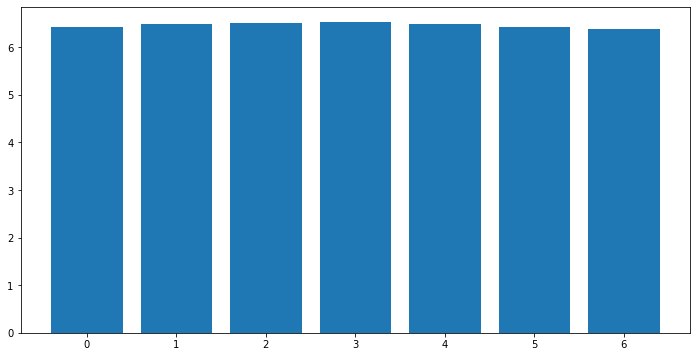

In [12]:
### Your code is here
fig = plt.figure()
fig.set_size_inches(12,6)
plt.bar(sorted(list(processed_data.day_of_week.unique())),processed_data.groupby('day_of_week', as_index=False)['log_trip_duration'].mean()['log_trip_duration'])




<BarContainer object of 6 artists>

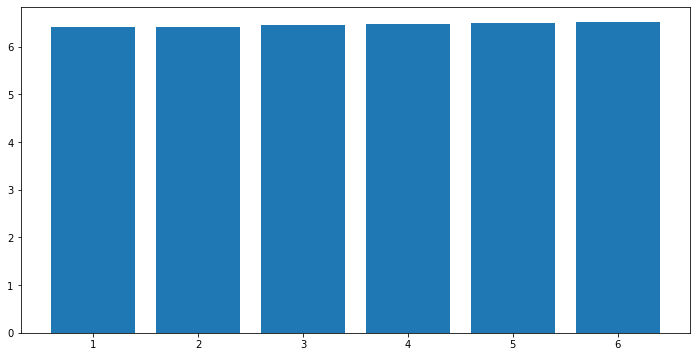

In [13]:
fig = plt.figure()
fig.set_size_inches(12,6)
plt.bar(sorted(list(processed_data.month.unique())),processed_data.groupby('month', as_index=False)['log_trip_duration'].mean()['log_trip_duration'])

<BarContainer object of 24 artists>

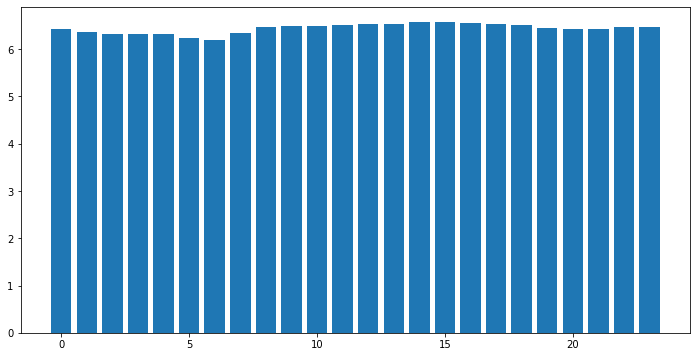

In [14]:
fig = plt.figure()
fig.set_size_inches(12,6)
plt.bar(sorted(list(processed_data.hour.unique())),processed_data.groupby('hour', as_index=False)['log_trip_duration'].mean()['log_trip_duration'])

{'whiskers': [<matplotlib.lines.Line2D at 0x7feb0dbc3590>,
 'caps': [<matplotlib.lines.Line2D at 0x7feb0d06dd10>,
 'boxes': [<matplotlib.lines.Line2D at 0x7feb0d07cdd0>],
 'medians': [<matplotlib.lines.Line2D at 0x7feb0d0a2210>],
 'fliers': [<matplotlib.lines.Line2D at 0x7feb0d12ff90>],
 'means': []}

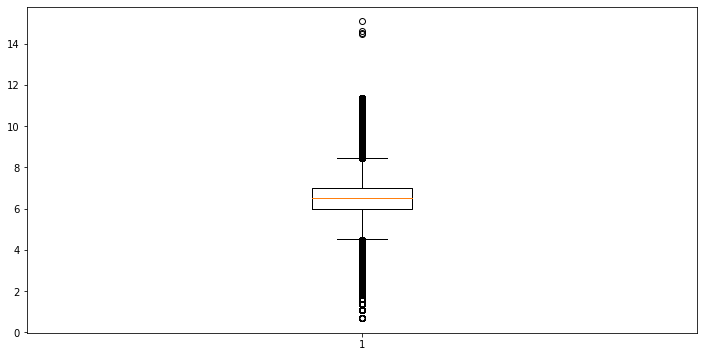

In [15]:
fig = plt.figure()
fig.set_size_inches(12,6)
plt.boxplot(processed_data.log_trip_duration)

In [16]:
import seaborn as sns
color = sns.color_palette()
fig = plt.figure()
fig.set_size_inches(12,6)

%matplotlib inline

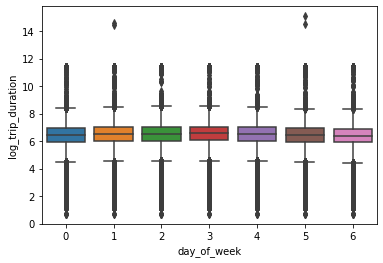

In [17]:
sns.boxplot(x = "day_of_week",y = 'log_trip_duration',data = processed_data)





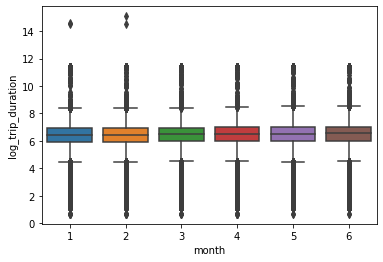

In [18]:
sns.boxplot(x = "month",y = 'log_trip_duration',data = processed_data)

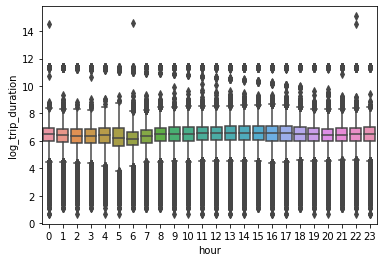

In [19]:
sns.boxplot(x ="hour",y = 'log_trip_duration',data = processed_data)

Кажется, что полученные выводы из графиков выше достаточны для того, чтобы посчитать признаки, связанные с временем/датой поездки, достаточно важными. На их основе выделим еще пару.

Добавьте следующие бинарные признаки:


1. Была ли в день поездки буря (основываясь на единственном обнаруженном таком дне)
2. Является ли время поездки статистически самым проблемным, то есть час пиком?

Для создания 2ой фичи используйте следующую логику: посчитаем для каждой пары "день недели"-"время суток" среднее значение таргета. Найдем топ-10 самых "больших" пар. Если поездка была совершена во входящее в этот топ время, то ставим 1. Иначе - 0. Получается бинарный признак.

P.S. назовите колонки **anomaly** и **traffic_jam**

In [20]:
### Создадим первый бинарный признак
### Your code is here
processed_data["anomaly"] = 0
processed_data["week"] = processed_data.pickup_datetime.dt.week
processed_data.loc[((processed_data.week == 3)& (processed_data.day_of_week == 5)),"anomaly"] = 1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  after removing the cwd from sys.path.


In [21]:
processed_data = processed_data.drop(columns = "week")

In [22]:
processed_data

,vendor_id,passenger_count,store_and_fwd_flag,distance_km,log_trip_duration,pickup_datetime,date,day_of_week,hour,month,anomaly
id,,,,,,,,,,,
id2875421,1,930.399753,0,1.500479,6.122493,2016-03-14 17:24:55,2016-03-14,0,17,3,0
id2377394,0,930.399753,0,1.807119,6.498282,2016-06-12 00:43:35,2016-06-12,6,0,6,0
id3858529,1,930.399753,0,6.392080,7.661527,2016-01-19 11:35:24,2016-01-19,1,11,1,0
id3504673,1,930.399753,0,1.487155,6.063785,2016-04-06 19:32:31,2016-04-06,2,19,4,0
id2181028,1,930.399753,0,1.189925,6.077642,2016-03-26 13:30:55,2016-03-26,5,13,3,0
...,...,...,...,...,...,...,...,...,...,...,...
id2376096,1,1053.529749,0,1.226296,6.658011,2016-04-08 13:31:04,2016-04-08,4,13,4,0
id1049543,0,930.399753,0,6.056935,6.486161,2016-01-10 07:35:15,2016-01-10,6,7,1,0
id2304944,1,930.399753,0,7.832952,6.639876,2016-04-22 06:57:41,2016-04-22,4,6,4,0


In [23]:
### Создадим второй бинарный признак
### Your code is here
#a = [x for x in processed_data.groupby(["day_of_week","hour"])["log_trip_duration"].count().sort_values(ascending = False).head(10).index]
s = [x for x in processed_data.groupby(["day_of_week","hour"])["log_trip_duration"].mean().sort_values(ascending = False).head(10).index]

In [24]:
processed_data["traffic_jam"] = 0
processed_data

,vendor_id,passenger_count,store_and_fwd_flag,distance_km,log_trip_duration,pickup_datetime,date,day_of_week,hour,month,anomaly,traffic_jam
id,,,,,,,,,,,,
id2875421,1,930.399753,0,1.500479,6.122493,2016-03-14 17:24:55,2016-03-14,0,17,3,0,0
id2377394,0,930.399753,0,1.807119,6.498282,2016-06-12 00:43:35,2016-06-12,6,0,6,0,0
id3858529,1,930.399753,0,6.392080,7.661527,2016-01-19 11:35:24,2016-01-19,1,11,1,0,0
id3504673,1,930.399753,0,1.487155,6.063785,2016-04-06 19:32:31,2016-04-06,2,19,4,0,0
id2181028,1,930.399753,0,1.189925,6.077642,2016-03-26 13:30:55,2016-03-26,5,13,3,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
id2376096,1,1053.529749,0,1.226296,6.658011,2016-04-08 13:31:04,2016-04-08,4,13,4,0,0
id1049543,0,930.399753,0,6.056935,6.486161,2016-01-10 07:35:15,2016-01-10,6,7,1,0,0
id2304944,1,930.399753,0,7.832952,6.639876,2016-04-22 06:57:41,2016-04-22,4,6,4,0,0


In [25]:
for i in s:
  processed_data.loc[((processed_data.day_of_week == i[0]) & (processed_data.hour == i[1])),"traffic_jam"] = 1

Теперь колонки **pickup_datetime**, **date** можно убрать. А про оставшиеся **day_of_week**, **hour**, **month** необходимо подумать:

- С одной стороны, первые две можно убрать, так как на их основе была создана колонка **traffic_jam**
- С другой стороны, зависимость с колонкой **traffic_jam** нелинейная, поэтому можно попробовать использовать все фичи в комбинации. Конечно, лучше попробовать оба варианта и проэкспериментировать, но ради упрощения - оставим все колонки. Хоть **day_of_week**, **hour** и описываются числами, мы понимаем, что это скорее категориальные фичи. Потому что, например, отношение между 23:00 и 00:00 не такое же, как между числами 23 и 0. Закодируем их с помощью OneHotEncoder. 
- Последняя (**month**) очевидно категориальная. Можно закодировать ее тоже через OneHotEncoder.

In [26]:
processed_data = processed_data.drop(['pickup_datetime', 'date'], axis=1)

In [27]:
### Делаем OneHotEncoding и конкатим с processed_data

processed_data = pd.get_dummies(data=processed_data, columns=[col for col in ['day_of_week', 'hour', 'month']], drop_first=True)

In [28]:
processed_data.head(5)

,vendor_id,passenger_count,store_and_fwd_flag,distance_km,log_trip_duration,anomaly,traffic_jam,day_of_week_1,day_of_week_2,day_of_week_3,...,hour_19,hour_20,hour_21,hour_22,hour_23,month_2,month_3,month_4,month_5,month_6
id,,,,,,,,,,,,,,,,,,,,,
id2875421,1,930.399753,0,1.500479,6.122493,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
id2377394,0,930.399753,0,1.807119,6.498282,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
id3858529,1,930.399753,0,6.392080,7.661527,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
id3504673,1,930.399753,0,1.487155,6.063785,0,0,0,1,0,...,1,0,0,0,0,0,0,1,0,0
id2181028,1,930.399753,0,1.189925,6.077642,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [29]:
s

[(3, 14),
 (3, 15),
 (2, 15),
 (2, 11),
 (2, 13),
 (2, 14),
 (1, 11),
 (3, 11),
 (4, 15),
 (3, 16)]

In [30]:
processed_data.head(5).to_csv("answer",sep=",")

In [31]:
round(processed_data.corr()["distance_km"]["passenger_count"],3)

0.017

In [32]:
X = processed_data.drop(columns = "log_trip_duration")
y = processed_data["log_trip_duration"]

Что же, мы с Вами научились с помощью EDA визуализаций понимать важность признаков не только постфактум, но и до того, как сформировался финальный датасет - на этапе **выделения базовых фичей**.

Обратимся теперь к методам фильтрации - например, применим корреляционный анализ для одной пары фичей, чтобы понять, нет ли относительно этих колонок в нашем датасете избытка информации. 

Вспомним так же изначальные вещественные признаки - distance_km, passenger_count

Посчитайте корреляцию между ними. Есть ли какие-то основания для беспокойства?

In [33]:
processed_data.head()

,vendor_id,passenger_count,store_and_fwd_flag,distance_km,log_trip_duration,anomaly,traffic_jam,day_of_week_1,day_of_week_2,day_of_week_3,...,hour_19,hour_20,hour_21,hour_22,hour_23,month_2,month_3,month_4,month_5,month_6
id,,,,,,,,,,,,,,,,,,,,,
id2875421,1,930.399753,0,1.500479,6.122493,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
id2377394,0,930.399753,0,1.807119,6.498282,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
id3858529,1,930.399753,0,6.392080,7.661527,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
id3504673,1,930.399753,0,1.487155,6.063785,0,0,0,1,0,...,1,0,0,0,0,0,0,1,0,0
id2181028,1,930.399753,0,1.189925,6.077642,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [34]:
processed_data.shape

(1458644, 41)

In [35]:
### На данный момент у нас 41 фича
### Представим, что хочется сократить их количество до 5.
### Воспользуемся для этим каким-нибудь методом обертки
### Например, метод прямого отбора

### Your code is here


In [36]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()

from sklearn.feature_selection import SequentialFeatureSelector

sfs = SequentialFeatureSelector(model, n_features_to_select=5)
sfs.fit(X, y)

SequentialFeatureSelector(estimator=LinearRegression(), n_features_to_select=5)

In [37]:
col_for_model = list(sfs.get_feature_names_out())

In [38]:
from sklearn.model_selection import train_test_split


In [39]:
X_train, X_test, y_train, y_test = train_test_split(X[col_for_model], y, test_size=0.2, random_state=42)

In [40]:
model = LinearRegression()

In [41]:
model.fit(X_train,y_train)

LinearRegression()

In [42]:
ans = model.predict(X_test)

In [43]:
print(round(((ans - y_test)**2).mean(),3))

0.398


In [44]:
### Перечислите фичи, которые окажутся наиболее желанными
### Your code is here


In [45]:
### Представим, что мы с Вами ничего не знаем про Кросс-Валидацию и отложенную выборку
### Замерьте качество линейной регрессии на данных фичах
### Сильно ли оно отличается от полученного на Кросс-Валидации в прошлом уроке в ДЗ?

### Your code is here

